## HW2 (Gibbs Sampling)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def plot_gaussian_from_points(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if len(x) != len(y):
        raise ValueError("x and y must be the same size")
    if len(x) < 2:
        raise ValueError("Need more data.")
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def plot_gaussian_from_parameters(mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
	mean : array-like, shape (2, )
    	Mean vector
    cov : array-like, shape (2,2)
    	Covariance matrix
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if len(mean) != 2:
        raise ValueError("Mean vector length should be 2.")
    if (cov.shape != (2, 2)):
    	raise ValueError("Covariance should be a 2x2 matrix.")
    #checking if cov is symmetric pos semidefinite
    if(cov[0, 1] != cov[1, 0]):
        raise ValueError("Covariance should be symmetric.")
    if(cov[0, 0] < 0 or cov[0, 0]*cov[1,1] - cov[0,1]**2 < 0):
        raise ValueError("Covariance should be positive semidefinite.")

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


# from random import random

# x = np.array([random()*5 for i in range(500)])
# y = np.array([random()*5 for i in range(500)])
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# ax.scatter(x, y)
# print(plot_gaussian_from_points(x, y, ax, n_std=1, edgecolor='red'))
# #print(plot_gaussian_from_parameters(np.array([2.5, 2.5]), np.cov(x, y), ax, n_std=1, edgecolor='red'))
# plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import gif
from IPython.display import Image
from random import random

In [4]:
def conditional_sampler(sampling_index, current_x, mean, cov):
    conditioned_index = 1 - sampling_index # 두 r.v.중 고르기
    a = cov[sampling_index, sampling_index] # Sigma00
    b = cov[sampling_index, conditioned_index] # Sigma01
    c = cov[conditioned_index, conditioned_index] # Sigma11
    
    mu = mean[sampling_index]+(b*(current_x[conditioned_index]-mean[conditioned_index]))/c
    sigma = sigma = np.sqrt(a-(b**2)/c)
    new_x = np.copy(current_x)
    new_x[sampling_index] = np.random.randn()*sigma + mu
    # [x_0, x_1] 꼴의 1x2 np.array를 return
    return new_x

In [13]:
def gibbs_sampler(initial_point, num_samples, mean, cov, create_gif=True):
    """
    [input 형태]
    initial_point = [x_0, x_1] = [-9.0, -9.0]
    num_samples = 100
    mean = np.array([0, 0])
    cov = np.array([[10, 3], 
                    [3, 5]])
    """
    frames = []  # for GIF
    
    point = np.array(initial_point)
    samples = np.empty([num_samples+1, 2])  # sampled points
    samples[0] = point
    tmp_points = np.empty([num_samples, 2]) # inbetween points (중간저장소)

    for i in range(num_samples):
        # 요 for loop이 gibbs sampler 핵심
        # point = [x_0, x_1]
        
        # Sample from p(x_0|x_1)
        point = conditional_sampler(0, point, mean, cov)
        tmp_points[i] = point
        if(create_gif):
            frames.append(plot_samples(samples, i+1, tmp_points, i+1, title="Num Samples: " + str(i)))
            
        # Sample from p(x_1|x_0)
        point = conditional_sampler(1, point, mean, cov)
        samples[i+1] = point
        if(create_gif):
            frames.append(plot_samples(samples, i+2, tmp_points, i+1, title="Num Samples: " + str(i+1)))
            
    if(create_gif):
        return samples, tmp_points, frames
    else:
        return samples, tmp_points

In [7]:
@gif.frame
def plot_samples(samples, num_samples, tmp_points, num_tmp, title="Gibbs Sampling", xlims=(-11, 11), ylims=(-11, 11)):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca()
    
    # Plot the true distribution
    plot_gaussian_from_parameters(mean, cov, ax, n_std=2, edgecolor='g', alpha=0.5, label="True Distribution")
    
    # Plot sampled points
    ax.scatter(samples[:num_samples, 0], samples[:num_samples, 1], c='b', s=10, label="Sampled Points")
    ax.scatter(samples[0, 0], samples[0, 1], marker='*', c='g', s=60, label="Initial Point")
    
    # Plot samples from conditional distribution
    ax.scatter(tmp_points[:num_tmp, 0], tmp_points[:num_tmp, 1], c='r', alpha=0.4, s=5, label="Temporary Points")
    
    # Keeping the axes scales same for good GIFS
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    # Plot lines
    if(num_tmp > 0):
        ax.plot([samples[num_samples-1, 0], tmp_points[num_tmp-1, 0]], 
                [samples[num_samples-1, 1], tmp_points[num_tmp-1, 1]], c='k', alpha=0.25)
        # Plot estimated Gaussian, ignoring the starting point
        if(num_samples > 2):
            plot_gaussian_from_points(samples[1:num_samples, 0], samples[1:num_samples, 1], 
                                      ax, n_std=2, edgecolor='b', alpha=0.5, label="Estimated Distribution")
    
    ax.legend(loc='upper left')
    ax.set_title(title)

In [8]:
mean = np.array([0, 0])
cov = np.array([[10, 3], 
                [3, 5]])

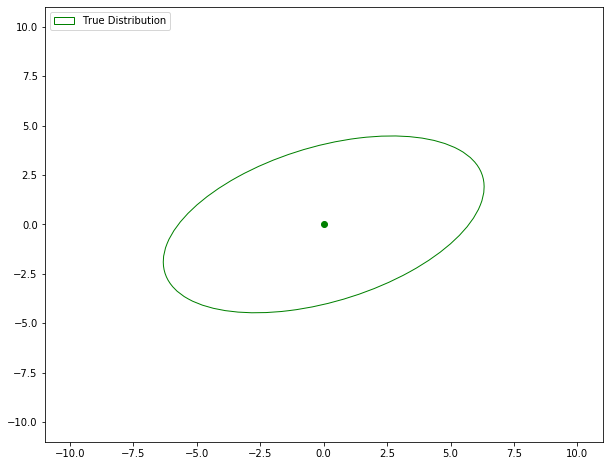

In [9]:
# Plot true distribution
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
plot_gaussian_from_parameters(mean, cov, ax, n_std=2, edgecolor='g', label="True Distribution")
ax.scatter(mean[0], mean[1], c='g')
ax.set_xlim((-11, 11))
ax.set_ylim((-11, 11))
ax.legend(loc='upper left')
plt.show()

In [14]:
initial_point = [-9.0, -9.0]
num_samples = 500
samples, tmp_points, frames = gibbs_sampler(initial_point, num_samples, mean, cov, create_gif=True)

In [15]:
# Creating the GIF
# 초당 한 번 update 할 수 있게 느으으으린 움짤임
gif.save(frames, "gibbs500.gif", duration=500)

## HW3 (NA Imputation)

In [17]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
diabetes = pd.read_csv('./diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [19]:
diabetes.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [20]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [21]:
# Mark invalid zero values as NaN (null)
temp_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
diabetes[temp_cols] = diabetes[temp_cols].replace(0, np.nan)
print(diabetes.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


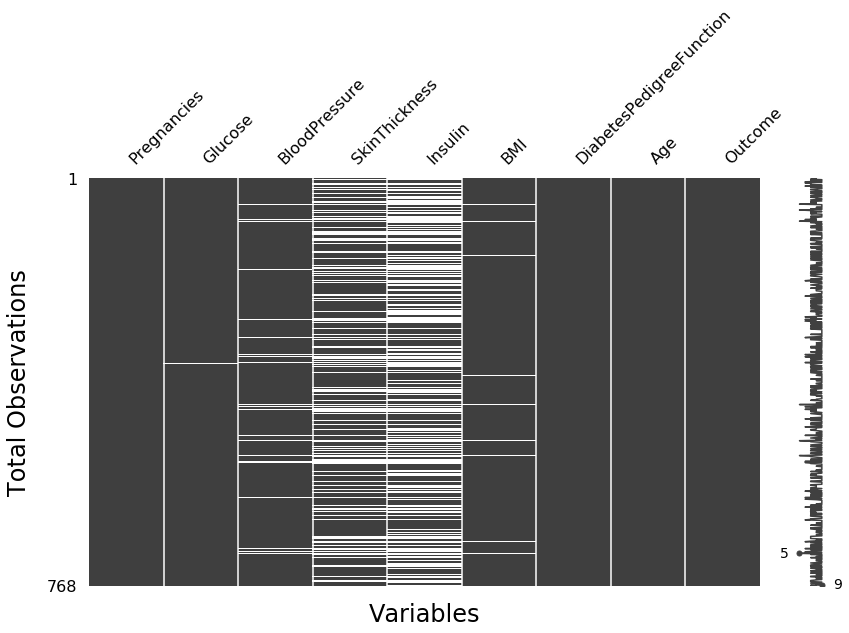

In [22]:
# Visualize the number of missing values as a matrix
fig = msno.matrix(diabetes, inline=False, figsize=(13.33,7.5))

# Add labels
plt.xlabel('Variables', size=24, labelpad=16)
plt.ylabel('Total Observations', size=24, labelpad=16)
plt.tick_params(axis='both', labelsize=16, length=8)

plt.show;

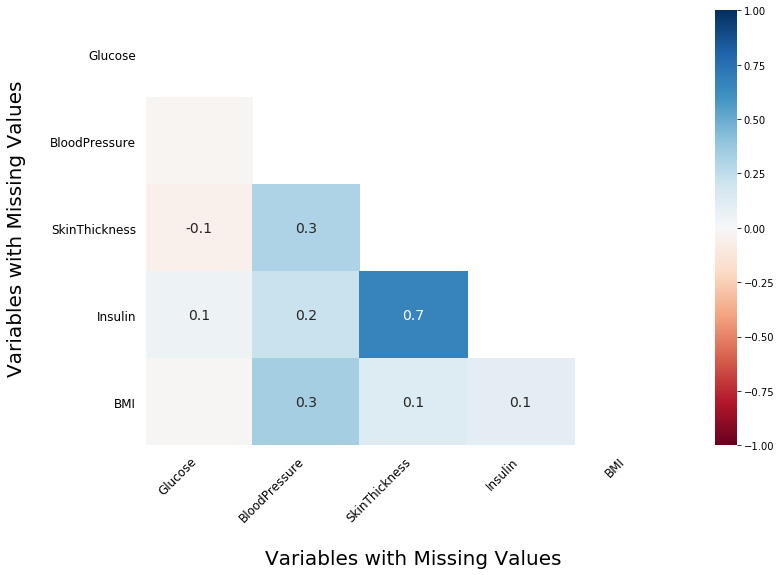

In [23]:
# Visualize the number of missing values as a heatmap
fig = msno.heatmap(diabetes, inline=False, figsize=(12,8))

# Add labels
plt.xlabel('Variables with Missing Values', size=20, labelpad=24)
plt.ylabel('Variables with Missing Values', size=20, labelpad=24)
plt.tick_params(axis='both', labelsize=12, length=6)

plt.show();

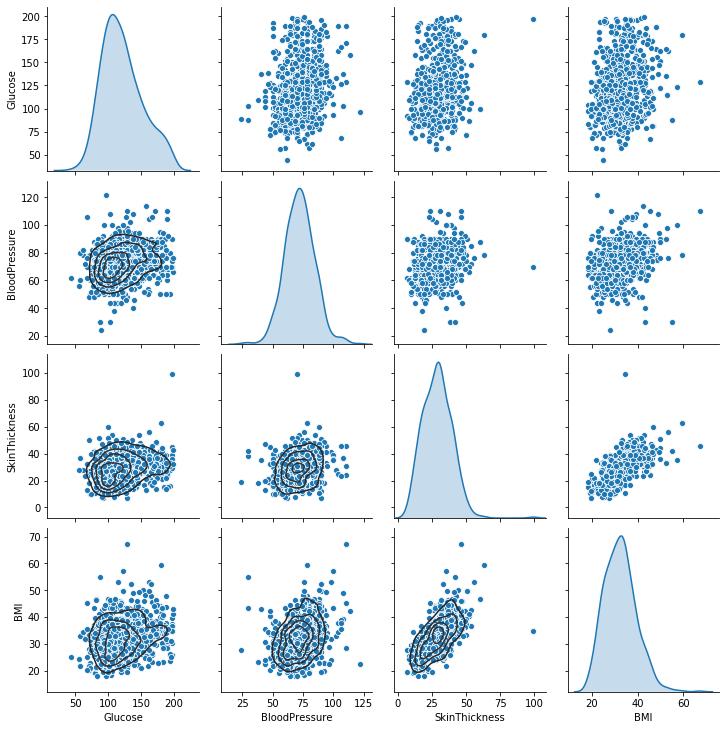

In [24]:
data = diabetes[['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']]

g = sns.pairplot(data, diag_kind = 'kde')
g.map_lower(sns.kdeplot, levels=4, color=".2")

In [25]:
n = data.shape[0]
p = data.shape[1]

S = 100

# 자주 쓰는 함수
inv = np.linalg.inv     # 역행렬 구하기
t = np.transpose        # transpose

# priors
# prior for mu ~ N(  ,  )
# mean vector mu_0
mu0 = data.mean().to_numpy()    # column mean

# covariance matrix Lambda0 : 공분산행렬 만들기
sd0 = mu0 / 2
L0 = np.ones((p,p))*0.1       # Lambda0 in prior
di = np.diag_indices(p)       # diagonal index indicator
L0[di] = 1                    # 일단 분산을 1로 unit
L0 = L0 * np.outer(sd0, sd0)  # off-diagonal terms

# prior for Sigma ~ Inv-Wihsart(   ,)
nu0 = p + 2                   # first param
S0 = (n-p-1)*L0

# miso
Sigma = S0                    # mu의 full conditional posterior를 초기화하는데 필요 
fill_data = data.copy()       # imputate할 dataset copy 만들기
O = data.isna().to_numpy()*1  # indicator variable for 결측치

# Naive imputation
for col in fill_data.columns:
    # 일단 mean imputation
    # 아마 계산시 nan 있어서 생기는 error를 방지하기 위해
    fill_data[col].fillna(fill_data[col].mean(), inplace=True)

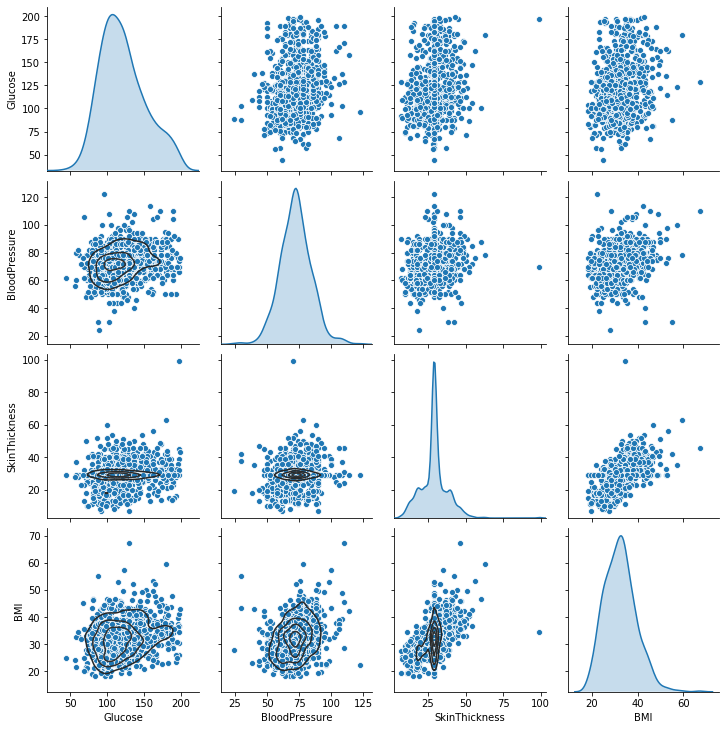

In [26]:
g_naive = sns.pairplot(fill_data, diag_kind='kde')
g_naive.map_lower(sns.kdeplot, levels=4, color='.2')

In [27]:
for s in range(S):
    # update mu
    ybar = fill_data.mean().to_numpy()
    Ln = inv(inv(L0) + inv(Sigma)*n)  # Lambda_n
    mun = np.matmul(Ln, np.matmul(inv(L0), mu0) + np.matmul(n*inv(Sigma), ybar)) # mu_n
    Mu = stats.multivariate_normal.rvs(mun, Ln, 1)
    
    # update Sigma
    S_mu = np.matmul(t(fill_data - Mu).to_numpy(), (fill_data-Mu).to_numpy())
    Sn = S0 + S_mu
    # sample Sigma from full conditional probaiblity given mu & y
    Sigma = inv(stats.wishart.rvs(nu0+n, inv(Sn), 1))
    
    # update missing data
    for i in range(n):
        
        # row별로 돌아가면서 1x4 array에 대해서 imputation
        # [T, F, F, T] 등의 형태로 indexing
        a = O[i,]==0        # i번째 row에 결측치 없는 위치
        b = O[i,]==1        # i번째 row에 결측치 있는 위치
        
        if sum(b)!=0:   # 결측치가 하나라도 있으면 imputation 진행!
            iSa = inv(Sigma[np.outer(a,a)].reshape(sum(a), sum(a)))
            beta_j = np.matmul(Sigma[np.outer(b,a)].reshape(sum(b), sum(a)), iSa)
            
            # Covariance Matrix for MVN distribution
            Sigma_j = Sigma[np.outer(b,b)].reshape(sum(b), sum(b)) - np.linalg.multi_dot([Sigma[np.outer(b,a)].reshape(sum(b), sum(a)), iSa, Sigma[np.outer(a,b)].reshape(sum(a), sum(b))])
            
            # Mean Vector for MVN distribution
            mu_j = Mu[b] + np.matmul(beta_j, t(fill_data.iloc[i,a])-Mu[a])
            
            # MVN에서 결측치 있는 위치 (b)만 sampling한 값으로 채우기!
            fill_data.iloc[i,b] = stats.multivariate_normal.rvs(mu_j, Sigma_j, 1)
            
    if s%10==0:
        print(s,"/",S)

0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100


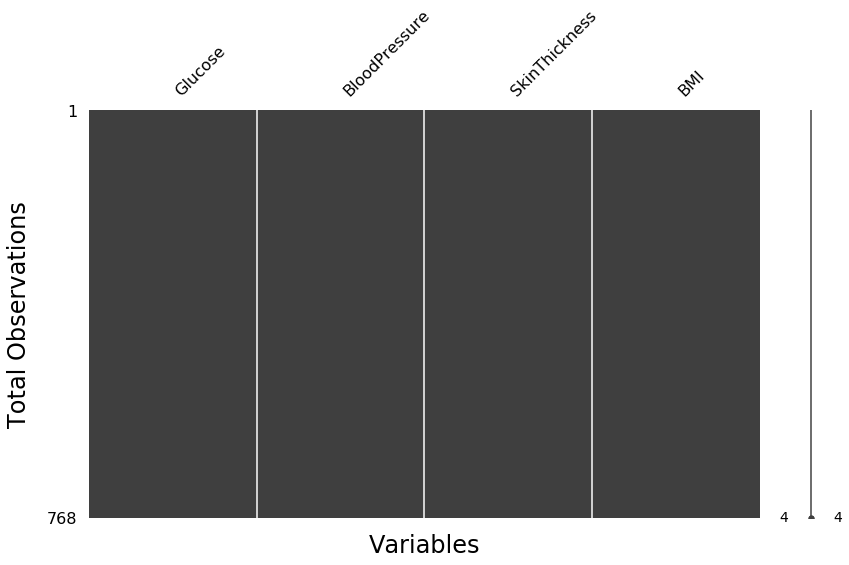

In [28]:
# Visualize the number of missing values as a matrix
fig = msno.matrix(fill_data, inline=False, figsize=(13.33,7.5))

# Add labels
plt.xlabel('Variables', size=24, labelpad=16)
plt.ylabel('Total Observations', size=24, labelpad=16)
plt.tick_params(axis='both', labelsize=16, length=8)

plt.show;

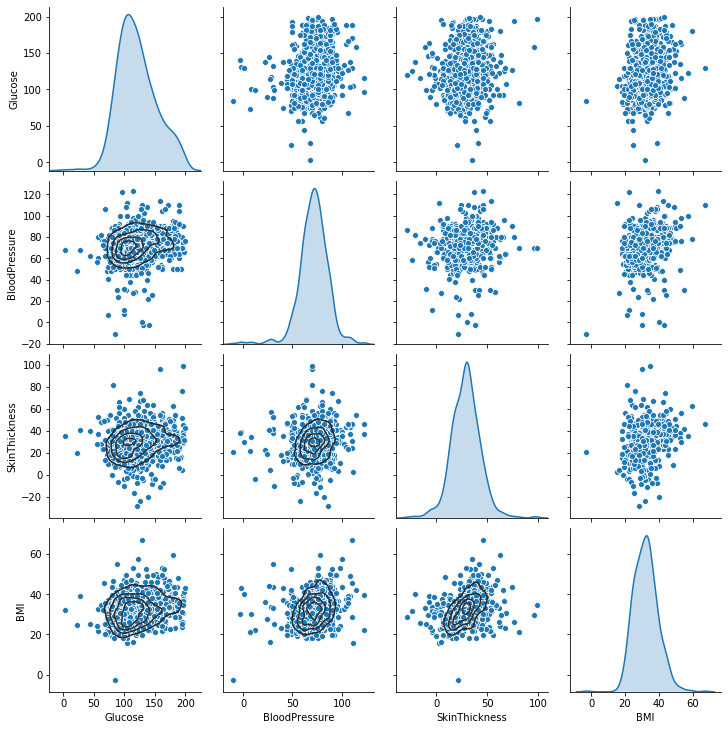

In [29]:
g_filled = sns.pairplot(fill_data, diag_kind="kde")
g_filled.map_lower(sns.kdeplot, levels=4, color=".2")